In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/signature-forgery-main.zip -d /content/drive/MyDrive/signature-forgery

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-11.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-12.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-13.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-14.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-15.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-78-G-16.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-79-G-01.tif  
  inflating: /content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-79-G-02.tif

In [4]:
# cd /content/drive/MyDrive/signature-forgery/signature-forgery-main

/content/drive/MyDrive/signature-forgery/signature-forgery-main


# Leegality Assessment Submission

The idea of the notebook is to find how much match is between 2 signatures which can be used to find whether the second signature is a genuine one, or a fraud.

The applications of this can be varied sectors like banking, healthcare, education, insurance, etc, especially with the digital acceptance across different walks of life.

The notebook is split into four main components:
- __1. [Setup and Imports](#setup_and_imports)__
- __2. [Image Capture and Preprocessing](#image_capture_and_preprocessing)__
- __3. [Model Building and Enhancement](#model_building_and_enhancement)__
- __4. [Testing](#testing)__

In the second section, the data is gathered from the [Kaggle link](https://www.kaggle.com/datasets/ishanikathuria/handwritten-signature-datasets), which has three different datasets:

- __a. CEDAR__
- __b. BHSig260 Bengali__
- __c. BHSig260 Hindi__

For the purpose of time and usability, two sets have been used: __BHSig260 Bengali__
and __BHSig260 Hindi__.

Both the datasets can be downloaded from the link above manually or using Kaggle API.
The data are to be kept in a single folder (after extraction) in a structure as such:
```
|- data
    |- BHSig260 Bengali
    |- BHSig260 Hindi
```

## [Setup and Imports](#setup_and_imports)

### Setup

Run the following in the terminal in a new environment to setup the required installations using `python==3.9.19`
```
pip3 install numpy
pip3 install tensorflow==2.7.0
pip3 install opencv-python
pip3 install notebook
pip3 install scikit-learn==1.4.1.post1
pip3 install tqdm
pip3 install protobuf==3.20.1
pip3 install matplotlib
```

### Imports

In [2]:
# Imports

import os
import shutil

import cv2
import numpy as np
from tqdm import tqdm

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

##  [Image Capture and Preprocessing](#image_capture_and_preprocessing)

In [5]:
curr_dir = os.getcwd()
curr_dir

'/content/drive/MyDrive/signature-forgery/signature-forgery-main'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Method to Segregate Data into Train, validation and test Sets

In [6]:
def get_train_val_test_data(arr):
        g_files = [x for x in arr if '-G-' in x]
        f_files = [x for x in arr if '-F-' in x]

        g_train_num = int(len(g_files)*0.7)

        g_train = g_files[:g_train_num]
        g_temp = g_files[g_train_num:]

        g_val_nums = len(g_temp) // 2
        g_val = g_temp[:g_val_nums]
        g_test = g_temp[g_val_nums:]

        f_train_num = int(len(f_files)*0.7)

        f_train = f_files[:f_train_num]
        f_temp = f_files[f_train_num:]

        f_val_nums = len(f_temp) // 2
        f_val = f_temp[:f_val_nums]
        f_test = f_temp[f_val_nums:]

        return g_train, g_val, g_test, f_train, f_val, f_test

The next code block splits the data from Kaggle into train_data, val_data and test_data under data folder.
The starting point is assumed to be the individual folders with .tiff images as provided by the Kaggle link.

In [57]:
def write_to_folder(primary_dir, secondary_dir, check_list):
    os.makedirs(os.path.join(primary_dir, secondary_dir), exist_ok=True)
    tmp_folder = os.path.join(primary_dir, secondary_dir)
    if data_type == check_list[0]:
        os.makedirs(os.path.join(tmp_folder, 'genuine'), exist_ok=True)
        dest_folder = os.path.join(tmp_folder, 'genuine')
    else:
        os.makedirs(os.path.join(tmp_folder, 'forge'), exist_ok=True)
        dest_folder = os.path.join(tmp_folder, 'forge')

    return dest_folder

In [ ]:
os.makedirs(os.path.join(curr_dir, "data"), exist_ok=True)
data_dir = os.path.join(curr_dir, "data")
train_dir = "train_data"
val_dir = "val_data"
test_dir = "test_data"

for language in os.listdir(data_dir):
    language_dir = os.path.join(data_dir, language)

    if os.path.isdir(language_dir):

        for user in os.listdir(language_dir):
            user_dir = os.path.join(language_dir, user)
            files = list(os.listdir(user_dir))
            g_train, g_val, g_test, f_train, f_val, f_test = get_train_val_test_data(files)


            for data_type in [g_train, g_val, g_test, f_train, f_val, f_test]:
                src_folder = user_dir
                if data_type in [g_train, f_train]:
                    dest_folder = write_to_folder(primary_dir=data_dir,
                                secondary_dir=train_dir,
                                check_list=[g_train, f_train])

                elif data_type in [g_val, f_val]:
                    dest_folder = write_to_folder(primary_dir=data_dir,
                                    secondary_dir=val_dir,
                                    check_list=[g_val, f_val])

                elif data_type in [g_test, f_test]:
                    dest_folder = write_to_folder(primary_dir=data_dir,
                                    secondary_dir=test_dir,
                                    check_list=[g_test, f_test])


                # Copy each file in the list to the destination folder

                for file in data_type:
                    src_string = os.path.join(src_folder, file)
                    shutil.copy(src_string, dest_folder)

### Preprocessing

In [ ]:
filepath = os.path.join(curr_dir, 'data/train_data/genuine/B-S-1-G-01.tif')
filepath

'/content/drive/MyDrive/signature-forgery/signature-forgery-main/data/train_data/genuine/B-S-1-G-01.tif'

In [ ]:
img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (150, 150))
# img = img / 255.0  # Normalize pixel values
print(img)
img = np.asarray(img)
print()
print(img)
print()
X = [img]
print(X)
# y = [1]
# X, y = np.array(X), np.array(y)
# cv2.imshow("Image", img)
# # Wait for the user to press a key
# cv2.waitKey(0)

# # Close all windows
# cv2.destroyAllWindows()

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]


In [ ]:
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')

dtype: uint8, shape: (150, 150), min: 0, max: 255


### Preprocessing Methods

In [7]:
# Function to load and preprocess images
# Change to Grayscale
# Resize
# Normalize
def preprocess_images(directory, label, img_size=(150, 150)):
    X = []
    y = []
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize pixel values
            img = np.asarray(img)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [8]:
# Load and preprocess data

def get_preprocessed_data(directory):
    X = []
    y = []
    for i, data_type in tqdm(enumerate(os.listdir(data_dir)), total=len(os.listdir(data_dir)), desc='Progress...'):
        type_dir = os.path.join(data_dir, data_type)
        if os.path.isdir(type_dir):
            # Load genuine signatures
            if 'genuine' in type_dir:
                genuine_X, genuine_y = preprocess_images(type_dir, label=1)
                X.extend(genuine_X)
                y.extend(genuine_y)

            else:
                forged_X, forged_y = preprocess_images(type_dir, label=0)
                X.extend(forged_X)
                y.extend(forged_y)

    X = np.array(X)
    y = np.array(y)
    # Set the seed to ensure similar distribtution across runs...
    np.random.seed(42)
    shuffled_indices = np.random.permutation(X.shape[0])

    # Shuffle arrays using shuffled indices
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    return X_shuffled, y_shuffled

In [9]:
def report(model, X_test, y_test):
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

    # Generate classification report
    print(classification_report(y_test, y_pred, target_names=['Forged', 'Genuine']))

## [Model Building and Enhancement](#model_building_and_enhancement)

#### Training, Validation and Test Sets

In [ ]:
data_dir = os.path.join(os.path.join(curr_dir, "data"), "train_data")
X_train, y_train = get_preprocessed_data(directory=data_dir)

Progress...: 100%|██████████| 2/2 [03:44<00:00, 112.28s/it]


In [ ]:
data_dir = os.path.join(os.path.join(curr_dir, "data"), "val_data")
X_val, y_val = get_preprocessed_data(directory=data_dir)

Progress...: 100%|██████████| 2/2 [00:33<00:00, 16.89s/it]


In [ ]:
data_dir = os.path.join(os.path.join(curr_dir, "data"), "test_data")
X_test, y_test = get_preprocessed_data(directory=data_dir)

Progress...: 100%|██████████| 2/2 [00:41<00:00, 20.84s/it]


### Model Architectures

__Handwritten Signature Forgery Detection using CNN - _Jerome Gideon S, Anurag, Kandulna, Aron Abhishek Kajur, Diana A, Kumudha Raimond___ (https://www.sciencedirect.com/science/article/pii/S1877050918320301)

In [ ]:
# Model architecture
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Display the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Model Training

Number of batches = len(X_train)//batch_size

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30, batch_size=32,
                    callbacks = [early_stopping])

Epoch 1/30
301/301 [==============================] - 18s 31ms/step - loss: 0.6370 - accuracy: 0.6499 - val_loss: 0.5554 - val_accuracy: 0.7331
Epoch 2/30
301/301 [==============================] - 7s 24ms/step - loss: 0.5082 - accuracy: 0.7589 - val_loss: 0.5098 - val_accuracy: 0.7466
Epoch 3/30
301/301 [==============================] - 8s 26ms/step - loss: 0.4029 - accuracy: 0.8118 - val_loss: 0.3845 - val_accuracy: 0.8280
Epoch 4/30
301/301 [==============================] - 7s 24ms/step - loss: 0.3072 - accuracy: 0.8716 - val_loss: 0.3354 - val_accuracy: 0.8540
Epoch 5/30
301/301 [==============================] - 8s 26ms/step - loss: 0.2325 - accuracy: 0.9045 - val_loss: 0.2726 - val_accuracy: 0.8868
Epoch 6/30
301/301 [==============================] - 7s 24ms/step - loss: 0.1808 - accuracy: 0.9270 - val_loss: 0.3226 - val_accuracy: 0.8854
Epoch 7/30
301/301 [==============================] - 8s 26ms/step - loss: 0.1363 - accuracy: 0.9465 - val_loss: 0.2797 - val_accuracy: 0.906

In [ ]:
report(model=model1,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 9ms/step - loss: 0.2989 - accuracy: 0.8926
Test Loss: 0.2989, Test Accuracy: 0.8926
73/73 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      Forged       0.91      0.89      0.90      1300
     Genuine       0.87      0.89      0.88      1036

    accuracy                           0.89      2336
   macro avg       0.89      0.89      0.89      2336
weighted avg       0.89      0.89      0.89      2336



Not bad for a first model. Especially when the forged classes are more accuractely predicted.

In [ ]:
import matplotlib.pyplot as plt

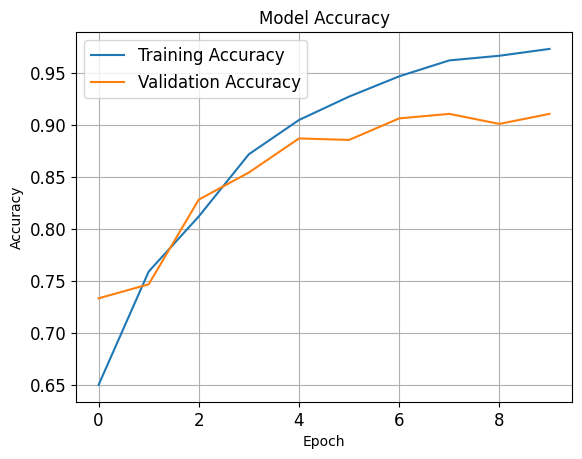

In [ ]:
# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

As can be seen the model still tries to learn the inherent patterns even after `10 epochs` while the validation sets are stagnated at 90%.

We shall try a different architecture to check the performance and see if it performs better.

In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),  # Additional hidden layer
    Dropout(0.5),                    # Additional dropout layer
    Dense(128, activation='relu'),  # Additional hidden layer
    Dropout(0.5),                    # Additional dropout layer
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [ ]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30, batch_size=32,
                    callbacks = [early_stopping])

Epoch 1/30
301/301 [==============================] - 13s 35ms/step - loss: 0.6310 - accuracy: 0.6411 - val_loss: 0.5623 - val_accuracy: 0.6888
Epoch 2/30
301/301 [==============================] - 9s 31ms/step - loss: 0.4896 - accuracy: 0.7751 - val_loss: 0.4371 - val_accuracy: 0.7866
Epoch 3/30
301/301 [==============================] - 9s 31ms/step - loss: 0.3705 - accuracy: 0.8409 - val_loss: 0.3634 - val_accuracy: 0.8439
Epoch 4/30
301/301 [==============================] - 9s 31ms/step - loss: 0.2582 - accuracy: 0.8948 - val_loss: 0.3230 - val_accuracy: 0.8646
Epoch 5/30
301/301 [==============================] - 9s 30ms/step - loss: 0.1759 - accuracy: 0.9307 - val_loss: 0.2930 - val_accuracy: 0.8945
Epoch 6/30
301/301 [==============================] - 10s 32ms/step - loss: 0.1123 - accuracy: 0.9565 - val_loss: 0.3029 - val_accuracy: 0.8974
Epoch 7/30
301/301 [==============================] - 9s 31ms/step - loss: 0.0673 - accuracy: 0.9749 - val_loss: 0.3680 - val_accuracy: 0.90

In [ ]:
report(model=model2,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 10ms/step - loss: 0.3125 - accuracy: 0.8985
Test Loss: 0.3125, Test Accuracy: 0.8985
73/73 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      Forged       0.89      0.93      0.91      1300
     Genuine       0.91      0.86      0.88      1036

    accuracy                           0.90      2336
   macro avg       0.90      0.89      0.90      2336
weighted avg       0.90      0.90      0.90      2336



As we see even with more layers added in, the validation accuracy doesnot improve while the training accuracy improves by about `1.0%`. So we can check the general performance on test set and make a decision on the model to optimize.

However, the recall on Forged is better which is a good indication as correctly classifying forged as forged is the target.

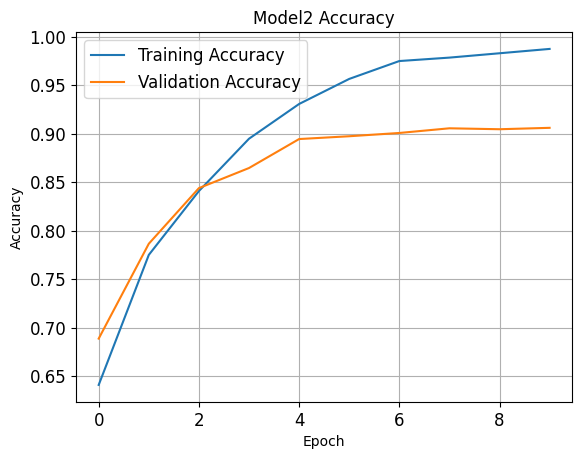

In [ ]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Evaluate Model 1 on the test set
test_loss_1, test_accuracy_1 = model1.evaluate(X_test, y_test)
print("Model 1 - Test Loss:", test_loss_1)
print("Model 1 - Test Accuracy:", test_accuracy_1)

# Evaluate Model 2 on the test set
test_loss_2, test_accuracy_2 = model2.evaluate(X_test, y_test)
print("Model 2 - Test Loss:", test_loss_2)
print("Model 2 - Test Accuracy:", test_accuracy_2)


73/73 [==============================] - 1s 12ms/step - loss: 0.2989 - accuracy: 0.8926
Model 1 - Test Loss: 0.29893970489501953
Model 1 - Test Accuracy: 0.8925513625144958
73/73 [==============================] - 1s 10ms/step - loss: 0.3125 - accuracy: 0.8985
Model 2 - Test Loss: 0.31252211332321167
Model 2 - Test Accuracy: 0.8985445499420166


As we can see both models have similar performance and Model 2 is more complex and takes more time to build.
Hence we shall select Model 1 as the base model. We shall try to optimize Model 1 for better generalization.

### Data Augmentation

In [ ]:
# Reshape the data to include the channel dimension
X_train_aug = np.expand_dims(X_train, axis=-1)
X_val_aug = np.expand_dims(X_val, axis=-1)
X_test_aug = np.expand_dims(X_test, axis=-1)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow(X_train_aug, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_aug, y_val, batch_size=32)

In [ ]:
# Model architecture with dropout regularization
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model with data augmentation
history3 = model3.fit(train_generator,
                    validation_data=val_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/30
301/301 [==============================] - 31s 98ms/step - loss: 0.6857 - accuracy: 0.5668 - val_loss: 0.6952 - val_accuracy: 0.5010
Epoch 2/30
301/301 [==============================] - 30s 100ms/step - loss: 0.6848 - accuracy: 0.5685 - val_loss: 0.7058 - val_accuracy: 0.5010
Epoch 3/30
301/301 [==============================] - 29s 97ms/step - loss: 0.6839 - accuracy: 0.5685 - val_loss: 0.7031 - val_accuracy: 0.5010
Epoch 4/30
301/301 [==============================] - 30s 99ms/step - loss: 0.6839 - accuracy: 0.5685 - val_loss: 0.7010 - val_accuracy: 0.5010
Epoch 5/30
301/301 [==============================] - 27s 89ms/step - loss: 0.6842 - accuracy: 0.5685 - val_loss: 0.7017 - val_accuracy: 0.5010
Epoch 6/30
301/301 [==============================] - 28s 92ms/step - loss: 0.6841 - accuracy: 0.5685 - val_loss: 0.7036 - val_accuracy: 0.5010


In [ ]:
report(model=model3,
       X_test=X_test_aug,
       y_test=y_test)

73/73 [==============================] - 1s 13ms/step - loss: 0.7989 - accuracy: 0.5565
Test Loss: 0.7989, Test Accuracy: 0.5565
73/73 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

      Forged       0.56      1.00      0.72      1300
     Genuine       0.00      0.00      0.00      1036

    accuracy                           0.56      2336
   macro avg       0.28      0.50      0.36      2336
weighted avg       0.31      0.56      0.40      2336



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The genuine class didnt perform well at all, probably with the augmented data, the genuine cases also got skewed. So no data augmentation to be used.

### Batch Normalization

Lets use batch normalization with learning scheduler to see if we can improve the model performance.

In [ ]:
# Model architecture with batch normalization
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=3,
                                 verbose=1)

# Train the model
history4 = model4.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/30
301/301 [==============================] - 20s 43ms/step - loss: 0.5613 - accuracy: 0.7492 - val_loss: 4.0125 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 2/30
301/301 [==============================] - 11s 37ms/step - loss: 0.3815 - accuracy: 0.8333 - val_loss: 0.3954 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 3/30
301/301 [==============================] - 11s 38ms/step - loss: 0.2867 - accuracy: 0.8813 - val_loss: 2.7557 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 4/30
301/301 [==============================] - 11s 37ms/step - loss: 0.2137 - accuracy: 0.9134 - val_loss: 3.3118 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 5/30
301/301 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9420
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
301/301 [==============================] - 12s 39ms/step - loss: 0.1487 - accuracy: 0.9420 - val_loss: 2.9792 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 6/30
301/301 [==============================] -

In [ ]:
report(model=model4,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 11ms/step - loss: 0.2524 - accuracy: 0.9259
Test Loss: 0.2524, Test Accuracy: 0.9259
73/73 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Forged       0.92      0.95      0.93      1300
     Genuine       0.93      0.90      0.91      1036

    accuracy                           0.93      2336
   macro avg       0.93      0.92      0.92      2336
weighted avg       0.93      0.93      0.93      2336



The performance and the metrics have all improved. But as we see the model is overfitting, we shall try to regularize the model by changing Dropout Values.

### Increase Regularization

In [ ]:
# Model architecture with batch normalization
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.6), # increased dropout
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=3,
                                 verbose=1)

# Train the model
history5 = model5.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/30
301/301 [==============================] - 17s 45ms/step - loss: 0.5815 - accuracy: 0.7417 - val_loss: 3.7796 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 2/30
301/301 [==============================] - 12s 39ms/step - loss: 0.4058 - accuracy: 0.8216 - val_loss: 74.5814 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 3/30
301/301 [==============================] - 11s 37ms/step - loss: 0.2935 - accuracy: 0.8766 - val_loss: 2.7916 - val_accuracy: 0.5072 - lr: 0.0010
Epoch 4/30
301/301 [==============================] - 11s 37ms/step - loss: 0.2062 - accuracy: 0.9173 - val_loss: 14.2807 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 5/30
301/301 [==============================] - 11s 37ms/step - loss: 0.1667 - accuracy: 0.9351 - val_loss: 25.4908 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 6/30
300/301 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9658
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
301/301 [==============================

In [ ]:
report(model=model5,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 13ms/step - loss: 0.2608 - accuracy: 0.9212
Test Loss: 0.2608, Test Accuracy: 0.9212
73/73 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

      Forged       0.91      0.95      0.93      1300
     Genuine       0.94      0.88      0.91      1036

    accuracy                           0.92      2336
   macro avg       0.92      0.92      0.92      2336
weighted avg       0.92      0.92      0.92      2336



Lets try once with a lower dropout value.

In [ ]:
# Model architecture with batch normalization
model6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4), # increased dropout
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=3,
                                 verbose=1)

# Train the model
history6 = model6.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/30
301/301 [==============================] - 16s 40ms/step - loss: 0.5467 - accuracy: 0.7527 - val_loss: 5.0313 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 2/30
301/301 [==============================] - 11s 38ms/step - loss: 0.3744 - accuracy: 0.8333 - val_loss: 1.8489 - val_accuracy: 0.4697 - lr: 0.0010
Epoch 3/30
301/301 [==============================] - 11s 37ms/step - loss: 0.2966 - accuracy: 0.8756 - val_loss: 2.6470 - val_accuracy: 0.5930 - lr: 0.0010
Epoch 4/30
301/301 [==============================] - 12s 39ms/step - loss: 0.1923 - accuracy: 0.9213 - val_loss: 0.7928 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 5/30
301/301 [==============================] - 11s 37ms/step - loss: 0.1058 - accuracy: 0.9608 - val_loss: 0.9507 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 6/30
301/301 [==============================] - 11s 37ms/step - loss: 0.0769 - accuracy: 0.9719 - val_loss: 7.5887 - val_accuracy: 0.5438 - lr: 0.0010
Epoch 7/30
299/301 [============================>.] - ETA:

In [ ]:
report(model=model6,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 15ms/step - loss: 0.2770 - accuracy: 0.9225
Test Loss: 0.2770, Test Accuracy: 0.9225
73/73 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

      Forged       0.94      0.92      0.93      1300
     Genuine       0.90      0.93      0.91      1036

    accuracy                           0.92      2336
   macro avg       0.92      0.92      0.92      2336
weighted avg       0.92      0.92      0.92      2336



Even reducing dropouts does not yield much better performance in terms of overfitting. We can stick to dropout = 0.5

### Additional Conv Layer

In [ ]:
# More complex model architecture
model7 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),  # Added layer
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the same callbacks
history7 = model7.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
301/301 [==============================] - 19s 41ms/step - loss: 0.5666 - accuracy: 0.7440 - val_loss: 0.8467 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 2/30
301/301 [==============================] - 11s 36ms/step - loss: 0.3632 - accuracy: 0.8423 - val_loss: 1.0913 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 3/30
301/301 [==============================] - 11s 36ms/step - loss: 0.2821 - accuracy: 0.8852 - val_loss: 2.6775 - val_accuracy: 0.5024 - lr: 0.0010
Epoch 4/30
301/301 [==============================] - 11s 37ms/step - loss: 0.2140 - accuracy: 0.9152 - val_loss: 0.3174 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 5/30
301/301 [==============================] - 11s 36ms/step - loss: 0.1406 - accuracy: 0.9456 - val_loss: 6.1850 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 6/30
301/301 [==============================] - 11s 36ms/step - loss: 0.1105 - accuracy: 0.9555 - val_loss: 2.3862 - val_accuracy: 0.5939 - lr: 0.0010
Epoch 7/30
299/301 [============================>.] - ETA:

In [ ]:
report(model=model7,
       X_test=X_test,
       y_test=y_test)

73/73 [==============================] - 1s 13ms/step - loss: 0.2247 - accuracy: 0.9379
Test Loss: 0.2247, Test Accuracy: 0.9379
73/73 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

      Forged       0.94      0.95      0.94      1300
     Genuine       0.94      0.92      0.93      1036

    accuracy                           0.94      2336
   macro avg       0.94      0.94      0.94      2336
weighted avg       0.94      0.94      0.94      2336



This is the best model we have achieved with pretty decent high scores across all metrics, and we shall use it for predictions.

In [ ]:
model7.save('/content/drive/MyDrive/signature-forgery/signature-forgery-main/models/model_07.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model7.save('/content/drive/MyDrive/signature-forgery/signature-forgery-main/models/model_07.keras')

## [Testing](#testing)

### Testing Match Percentage

In [48]:
class PredictMatch():
    def __init__(self,
                 model_path: str,
                 image_path_1: str,
                 image_path_2: str):
        self.model_path = model_path
        self.image_path_1 = image_path_1
        self.image_path_2 = image_path_2
        self.target_size = (150, 150)
        self.model = load_model(self.model_path)


    def preprocess_image_match(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.target_size)
        img = img.astype('float32')/255.0

        return img

    def calculate_match_percentage(self):
        img1 = self.preprocess_image_match(image_path = self.image_path_1)
        img2 = self.preprocess_image_match(image_path = self.image_path_2)

        # Stack images into a single batch to reduce retracing
        batch = np.stack([img1, img2])

        # Predict on the entire batch
        preds = self.model.predict(batch)

        pred_img1, pred_img2 = preds[0][0], preds[1][0]

        match_perc = 100 - abs(pred_img1 - pred_img2) * 100

        return match_perc

    def match_amount(self):
        return round(self.calculate_match_percentage(), 2)



In [52]:
# Both genuine

model_path='/content/drive/MyDrive/signature-forgery/signature-forgery-main/models/model_07.keras'
image_path_1='/content/drive/MyDrive/signature-forgery/signature-forgery-main/data/test_data/genuine/B-S-1-G-21.tif'
image_path_2='/content/drive/MyDrive/signature-forgery/signature-forgery-main/data/test_data/genuine/B-S-1-G-24.tif'

In [53]:
# Lets try to make predictions

obj = PredictMatch(model_path=model_path,
                   image_path_1=image_path_1,
                   image_path_2=image_path_2
                   )
print(obj.match_amount())

1/1 [==============================] - 0s 201ms/step
99.95


The match percentage between genuine signatures of the same user has high values.

In [54]:
# Image 1 genuine, Image 2 forge

model_path='/content/drive/MyDrive/signature-forgery/signature-forgery-main/models/model_07.keras'
image_path_1='/content/drive/MyDrive/signature-forgery/signature-forgery-main/data/test_data/genuine/B-S-1-G-21.tif'
image_path_2='/content/drive/MyDrive/signature-forgery/signature-forgery-main/data/test_data/forge/B-S-1-F-29.tif'

In [55]:
obj = PredictMatch(model_path=model_path,
                   image_path_1=image_path_1,
                   image_path_2=image_path_2
                   )
print(obj.match_amount())

1/1 [==============================] - 0s 283ms/step
0.04


The match percentage between genuine and forge dsignatures of the same user has low values.